In [1]:
%matplotlib notebook

from Inn2 import RadynversionNet, AtmosData, RadynversionTrainer
import loss as Loss
import pickle
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import torch
import torch.optim
import torch.utils.data
from torch.distributions.multivariate_normal import MultivariateNormal

from time import time

dev = 'cuda' if torch.cuda.is_available() else 'cpu'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
dataLocation1 = '/local0/scratch/HAlphaGridExportStatic/DoublePicoMegaPickle50.pickle'
# dataLocation3 = '/local0/scratch/HAlphaGridExportStatic/MiniBalancedTraining.pickle'
# dataLocation2 = '/local0/scratch/HAlphaGridExportStatic/TestPickle50.pickle'
# dataLocation = '/local0/scratch/Chris/DoublePicoMegaPickle50.pickle'
# dataLocation = 'G:\\DoublePicoMegaPickle.pickle'
balancedData = 'MiniBalancedTraining.pickle'

data = AtmosData([dataLocation1], resampleWl=30)
# data = AtmosData([balancedData], resampleWl=30)
data.split_data_and_init_loaders(500)


In [3]:
inRepr = [('ne', data.ne.shape[1]), ('temperature', data.temperature.shape[1]), ('vel', data.vel.shape[1]), ('!!PAD',)]
outRepr = [('LatentSpace', int(data.ne.shape[1]*4)), ('!!PAD',), ('Halpha', data.lines[0].shape[1]), ('Ca8542', data.lines[1].shape[1])]
model = RadynversionNet(inRepr, outRepr, dropout=0.00, zeroPadding=0, minSize=384, numInvLayers=5)

Node Inv0 has following input dimensions:
	 Output #0 of node Input (0-pad extra channels): (384,)

Node Permute0 has following input dimensions:
	 Output #0 of node Inv0: (384,)

Node Inv1 has following input dimensions:
	 Output #0 of node Permute0: (384,)

Node Permute1 has following input dimensions:
	 Output #0 of node Inv1: (384,)

Node Inv2 has following input dimensions:
	 Output #0 of node Permute1: (384,)

Node Permute2 has following input dimensions:
	 Output #0 of node Inv2: (384,)

Node Inv3 has following input dimensions:
	 Output #0 of node Permute2: (384,)

Node Permute3 has following input dimensions:
	 Output #0 of node Inv3: (384,)

Node Inv4 has following input dimensions:
	 Output #0 of node Permute3: (384,)

Node Output has following input dimensions:
	 Output #0 of node Inv4: (384,)



In [4]:
model.outSchema, model.inSchema, len(model.outSchema), len(model.inSchema), model

([('LatentSpace', 200), ('!!ZeroPadding', 124), ('Halpha', 30), ('Ca8542', 30)],
 [('ne', 50), ('temperature', 50), ('vel', 50), ('!!ZeroPadding', 234)],
 384,
 384,
 RadynversionNet(
   (module_list): ModuleList(
     (0): None
     (1): rev_multiplicative_layer(
       (s1): F_fully_connected_leaky(
         (d1): Dropout(p=0.0)
         (d2): Dropout(p=0.0)
         (d2b): Dropout(p=0.0)
         (fc1): Linear(in_features=192, out_features=384, bias=True)
         (fc2): Linear(in_features=384, out_features=384, bias=True)
         (fc2b): Linear(in_features=384, out_features=384, bias=True)
         (fc2d): Linear(in_features=384, out_features=384, bias=True)
         (fc3): Linear(in_features=384, out_features=192, bias=True)
         (nl1): LeakyReLU(negative_slope=0.01)
         (nl2): LeakyReLU(negative_slope=0.01)
         (nl2b): LeakyReLU(negative_slope=0.01)
         (nl2d): ReLU()
       )
       (t1): F_fully_connected_leaky(
         (d1): Dropout(p=0.0)
         (d2): D


fig, ax = plt.subplots(1, 2)
x, y = next(iter(data.trainLoader))
ax[0].plot(x[0, 0, :].numpy())
ax[1].plot(x[0, 1, :].numpy())
ax[1].plot(x[0, 2, :].numpy())

In [5]:
trainer = RadynversionTrainer(model, data, dev)
trainer.training_params(800, lr=1.5e-3, zerosNoiseScale=5e-2, wPred=4000.0, wLatent=900.0, wRev=1000.0,
#                         loss_latent=Loss.mmd_multiscale_on(dev, alphas=[3, 4, 6, 9, 16]),
                        loss_latent=Loss.mmd_multiscale_on(dev, alphas=[8, 11]),
#                         loss_backward=Loss.mmd_multiscale_on(dev, alphas=[4, 5, 6, 12, 30]),
                        loss_backward=Loss.mmd_multiscale_on(dev, alphas=[1.4, 2, 5.5, 7]),
                        loss_fit=Loss.mse)
totalEpochs = 0

<IPython.core.display.Javascript object>


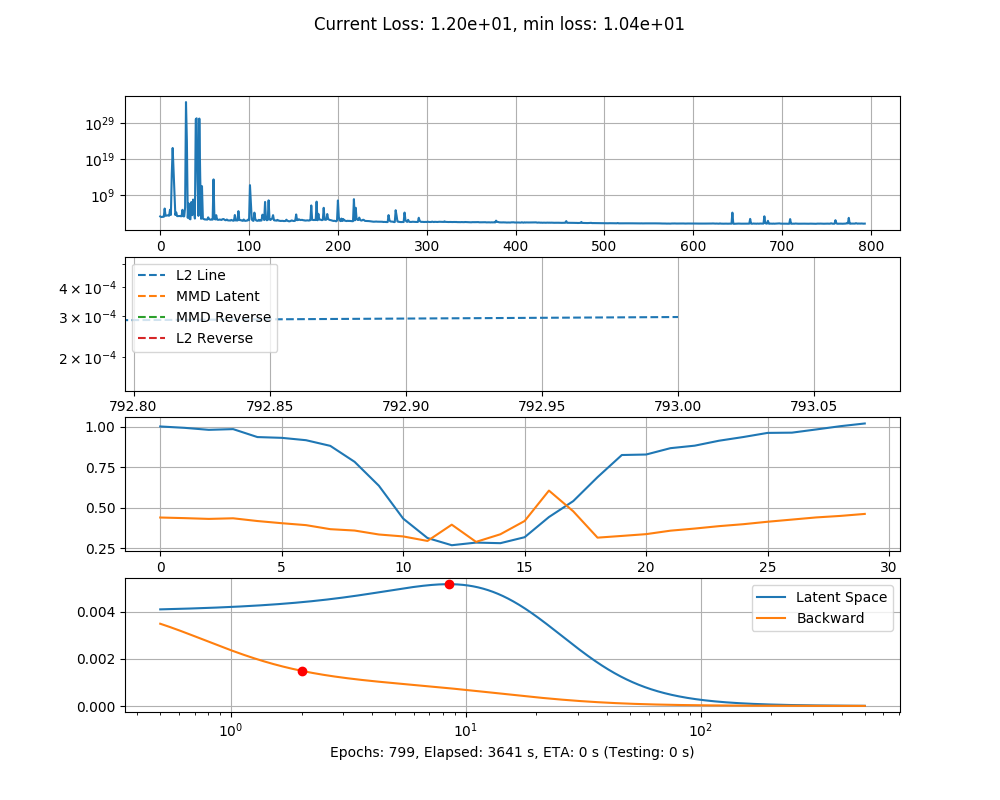

/usr/local/lib64/python3.6/site-packages/matplotlib/axes/_base.py:3018: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  self.set_xlim(upper, lower, auto=None)




Training took 60.69 minutes



In [6]:
losses = []
lossVec = [[] for _ in range(4)]
lossLabels = ['L2 Line', 'MMD Latent', 'MMD Reverse', 'L2 Reverse']
out = None
fig, axis = plt.subplots(4,1, figsize=(10,8))
# axis2 = axis[1].twinx()
# axis1a = axis[0].twinx()
fig.show()
fig.canvas.draw()
alphaRange, mmdF, mmdB, idxF, idxB = [1,1], [1,1], [1,1], 0, 0
try:
    tStart = time()
    for epoch in range(trainer.numEpochs):
        totalEpochs += 1

        trainer.scheduler.step()
        
        loss, indLosses = trainer.train(epoch)
        
        axis[0].clear()
#         axis1a.clear()
        axis[1].clear()
#         axis2.clear()
        axis[2].clear()
        axis[3].clear()
        if epoch > 5:
            for i in range(len(indLosses)):
                lossVec[i].append(indLosses[i])
            losses.append(loss)
            fig.suptitle('Current Loss: %.2e, min loss: %.2e' % (loss, np.min(np.abs(losses))))
            axis[0].semilogy(np.arange(len(losses)), np.abs(losses))
            for i, lo in enumerate(lossVec):
                axis[1].semilogy(np.arange(len(losses)), lo, '--', label=lossLabels[i])
            axis[1].legend(loc='upper left')
            tNow = time()
            elapsed = int(tNow - tStart)
            eta = int((tNow - tStart) / (epoch + 1) * trainer.numEpochs) - elapsed

            if epoch % 2 == 0:
                mses = trainer.test(maxBatches=1)
                lineProfiles = mses[2]
                
            if epoch % 5 == 0:
                alphaRange, mmdF, mmdB, idxF, idxB = trainer.review_mmd()
                
            axis[3].semilogx(alphaRange, mmdF, label='Latent Space')
            axis[3].semilogx(alphaRange, mmdB, label='Backward')
            axis[3].semilogx(alphaRange[idxF], mmdF[idxF], 'ro')
            axis[3].semilogx(alphaRange[idxB], mmdB[idxB], 'ro')
            axis[3].legend()

            testTime = time() - tNow
            axis[2].plot(lineProfiles[0, model.outSchema.Halpha].cpu().numpy())
            axis[2].plot(lineProfiles[0, model.outSchema.Ca8542].cpu().numpy())
            for a in axis:
                a.grid()
            axis[3].set_xlabel('Epochs: %d, Elapsed: %d s, ETA: %d s (Testing: %d s)' % (epoch, elapsed, eta, testTime))
            
            
        fig.canvas.draw()

except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-tStart)/60:.2f} minutes\n")
#     totalEpochs += len(losses)


In [36]:
trainer.test(maxBatches=-1)

(0.00017898936,
 0.00029500783,
 tensor([[ 1.1855,  1.2411, -0.7166,  ...,  0.1981,  0.2466,  0.3455],
         [-1.7108, -1.9464,  2.0314,  ...,  0.3454,  0.3525,  0.3627],
         [-0.2038, -0.0952,  2.1507,  ...,  0.3297,  0.3385,  0.3390],
         ...,
         [-0.3753, -0.4377, -1.6130,  ...,  0.4337,  0.4517,  0.4581],
         [-0.3721, -1.2678, -0.7990,  ...,  0.4300,  0.4457,  0.4570],
         [ 1.3521,  0.0099,  1.2467,  ...,  0.1692,  0.1678,  0.1729]],
        device='cuda:0'),
 tensor([[14.6550, 13.4681, 12.9026,  ...,  0.0060, -0.0050,  0.0020],
         [14.6639, 13.4634, 12.8946,  ...,  0.0068,  0.0105,  0.0019],
         [14.6868, 13.5042, 12.9282,  ..., -0.0273, -0.0045, -0.0012],
         ...,
         [14.6603, 13.4884, 12.9080,  ..., -0.0250, -0.0003,  0.0030],
         [14.6705, 13.4824, 12.9080,  ..., -0.0002,  0.0010, -0.0000],
         [14.7296, 13.5271, 12.9706,  ..., -0.0107, -0.0024, -0.0043]],
        device='cuda:0'))

<IPython.core.display.Javascript object>


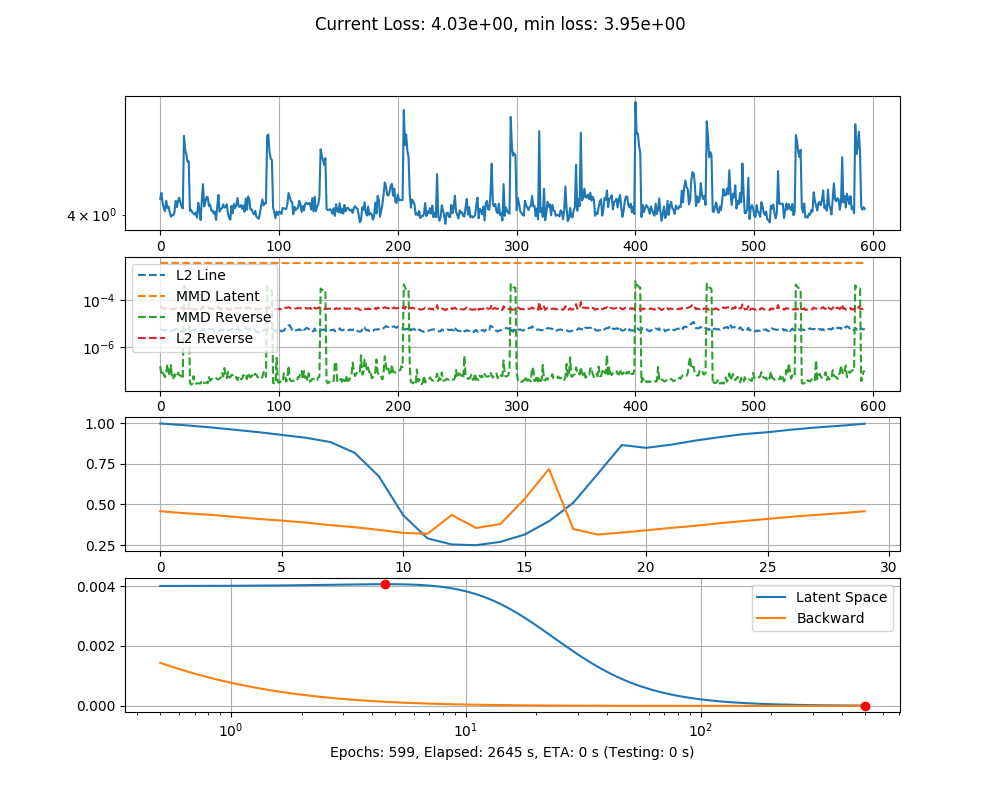



Training took 44.10 minutes

5.7999492e-05


<IPython.core.display.Javascript object>


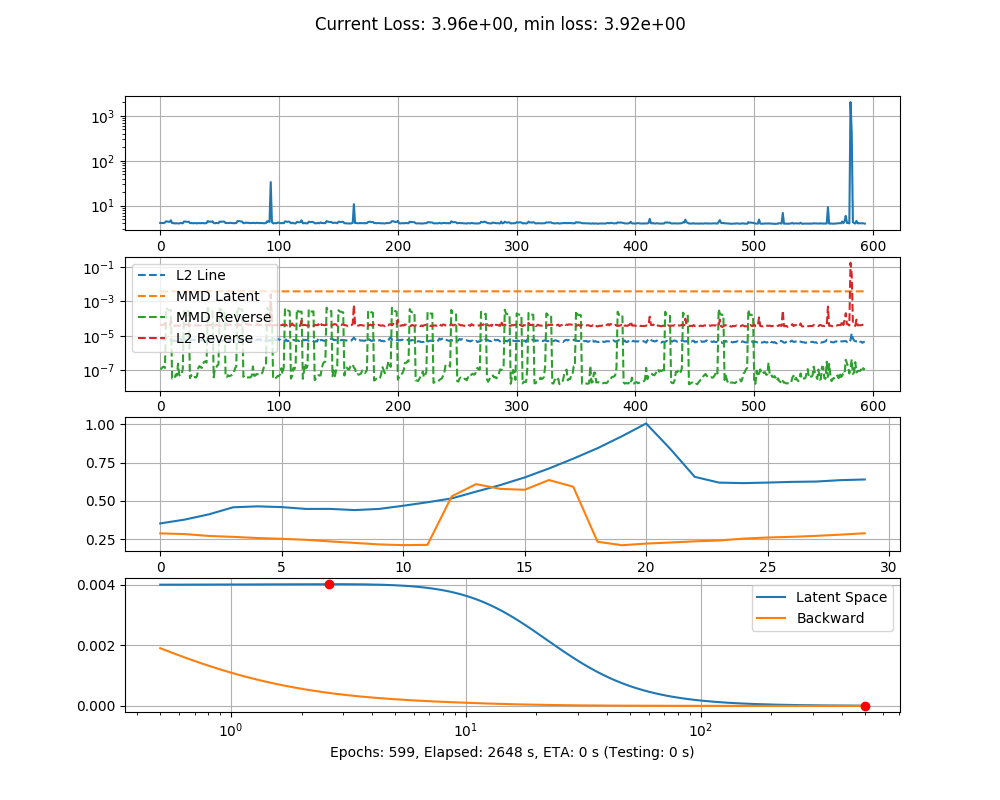



Training took 44.15 minutes

5.030135e-05


<IPython.core.display.Javascript object>


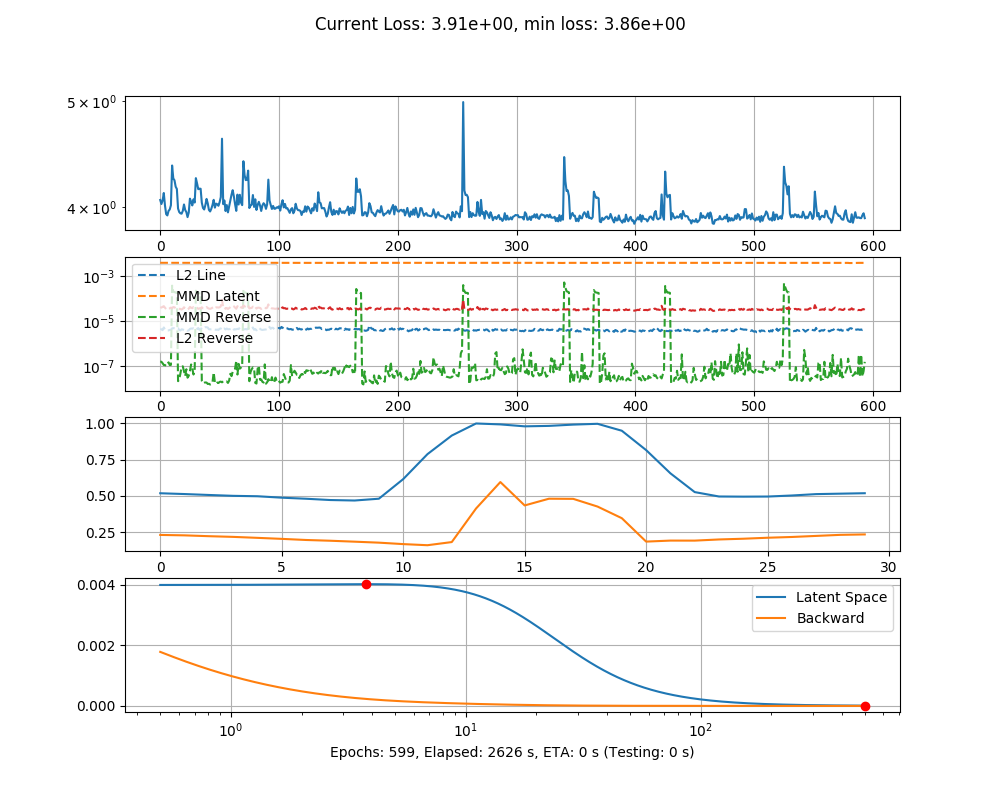



Training took 43.79 minutes

4.4616678e-05


<IPython.core.display.Javascript object>


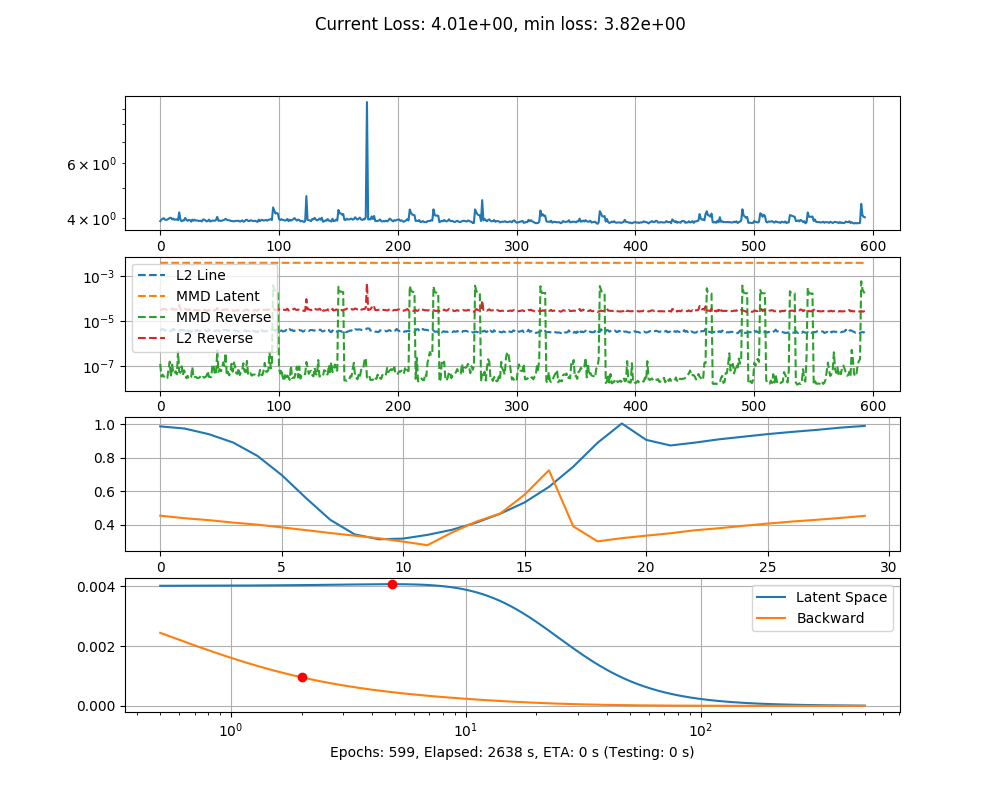



Training took 43.99 minutes

5.554529e-05


<IPython.core.display.Javascript object>


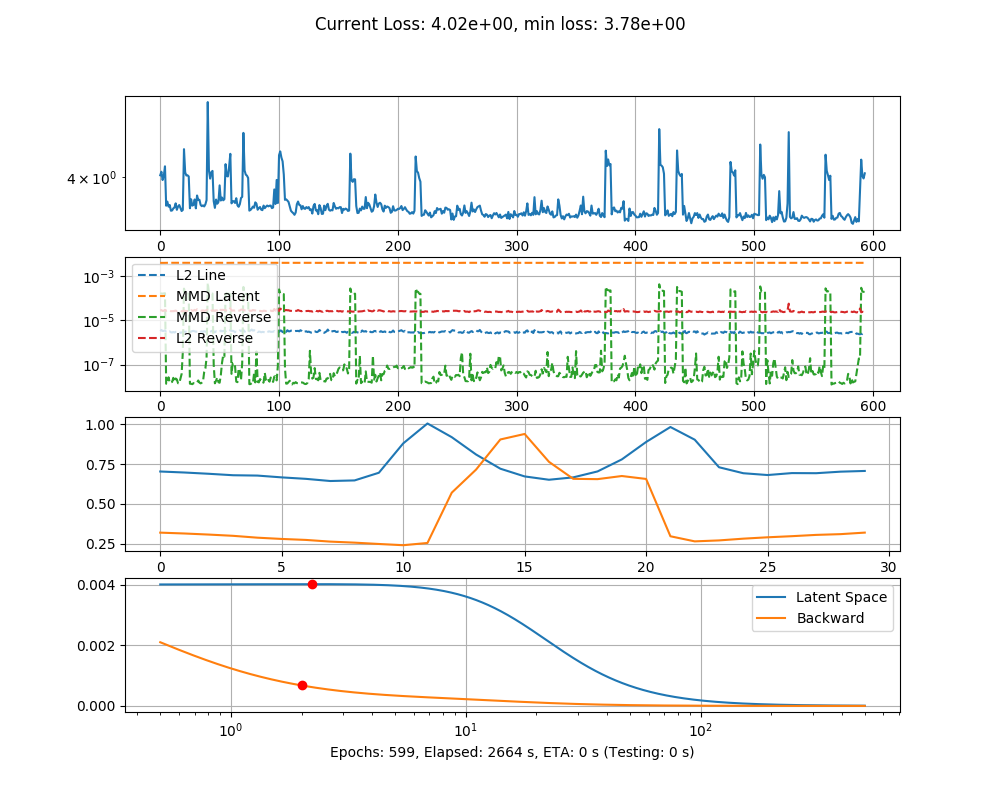



Training took 44.42 minutes

4.7529626e-05


In [71]:
prevTest = trainer.test(maxBatches=-1)
while True:
    save_checkpoint(training_checkpoint(), filename='checkpt_'+str(totalEpochs)+'_'+str(int(trainer.wPred))+'.pth.tar')
    trainer.numEpochs = 600
    trainer.fadeIn = False
    trainer.wPred += 1000
    
    # Do the training iter --  this is just a horrible copy and paste from above
    losses = []
    lossVec = [[] for _ in range(4)]
    lossLabels = ['L2 Line', 'MMD Latent', 'MMD Reverse', 'L2 Reverse']
    out = None
    fig, axis = plt.subplots(4,1, figsize=(10,8))
    # axis2 = axis[1].twinx()
    # axis1a = axis[0].twinx()
    fig.show()
    fig.canvas.draw()
    alphaRange, mmdF, mmdB, idxF, idxB = [1,1], [1,1], [1,1], 0, 0
    try:
        tStart = time()
        for epoch in range(trainer.numEpochs):
            totalEpochs += 1

            trainer.scheduler.step()

            loss, indLosses = trainer.train(epoch)

            axis[0].clear()
    #         axis1a.clear()
            axis[1].clear()
    #         axis2.clear()
            axis[2].clear()
            axis[3].clear()
            if epoch > 5:
                for i in range(len(indLosses)):
                    lossVec[i].append(indLosses[i])
                losses.append(loss)
                fig.suptitle('Current Loss: %.2e, min loss: %.2e' % (loss, np.min(np.abs(losses))))
                axis[0].semilogy(np.arange(len(losses)), np.abs(losses))
                for i, lo in enumerate(lossVec):
                    axis[1].semilogy(np.arange(len(losses)), lo, '--', label=lossLabels[i])
                axis[1].legend(loc='upper left')
                tNow = time()
                elapsed = int(tNow - tStart)
                eta = int((tNow - tStart) / (epoch + 1) * trainer.numEpochs) - elapsed

                if epoch % 2 == 0:
                    mses = trainer.test(maxBatches=1)
                    lineProfiles = mses[2]

                if epoch % 5 == 0:
                    alphaRange, mmdF, mmdB, idxF, idxB = trainer.review_mmd()

                axis[3].semilogx(alphaRange, mmdF, label='Latent Space')
                axis[3].semilogx(alphaRange, mmdB, label='Backward')
                axis[3].semilogx(alphaRange[idxF], mmdF[idxF], 'ro')
                axis[3].semilogx(alphaRange[idxB], mmdB[idxB], 'ro')
                axis[3].legend()

                testTime = time() - tNow
                axis[2].plot(lineProfiles[0, model.outSchema.Halpha].cpu().numpy())
                axis[2].plot(lineProfiles[0, model.outSchema.Ca8542].cpu().numpy())
                for a in axis:
                    a.grid()
                axis[3].set_xlabel('Epochs: %d, Elapsed: %d s, ETA: %d s (Testing: %d s)' % (epoch, elapsed, eta, testTime))


            fig.canvas.draw()

    except KeyboardInterrupt:
        pass
    finally:
        print(f"\n\nTraining took {(time()-tStart)/60:.2f} minutes\n")
        
    test = trainer.test()
    print(test[0])
    
#     if test[0] > prevTest[0] * 1.02:
#         break
        
#     prevTest = test
        
    if totalEpochs >= 12000:
        break
    

In [ ]:
# fig.canvas.draw()
# idxFor
trainer.numEpochs = 200
trainer.fadeIn = False
# trainer.zerosNoiseScale = 0.0
trainer.wPred = 9000
# trainer.wLatent = 200

In [129]:
load_checkpoint('checkpt_11400_25000.pth.tar')

=> loading checkpoint 'checkpt_11400_25000.pth.tar'
=> loaded checkpoint 'checkpt_11400_25000.pth.tar' (epoch 11400)


In [81]:
save_checkpoint(training_checkpoint(), filename='checkpt_12000_26000.pth.tar')

In [169]:
trainer.test(maxBatches=-1)

(5.7341807e-05,
 0.00025331578,
 tensor([[ 0.1914, -0.1937,  1.0533,  ...,  0.4362,  0.4492,  0.4585],
         [ 0.8167, -1.3895, -1.0897,  ...,  0.4231,  0.4335,  0.4428],
         [ 1.0239, -1.8461,  0.0883,  ...,  0.1615,  0.1712,  0.1709],
         ...,
         [-0.1316, -2.0085, -0.8831,  ...,  0.4319,  0.4450,  0.4565],
         [ 2.2585,  0.7382, -0.0363,  ...,  0.4351,  0.4460,  0.4550],
         [-0.1372,  0.2791,  0.8606,  ...,  0.2998,  0.3075,  0.3165]],
        device='cuda:0'),
 tensor([[ 1.4644e+01,  1.3477e+01,  1.2917e+01,  ..., -6.2362e-03,
           5.5561e-04,  1.3725e-03],
         [ 1.4664e+01,  1.3481e+01,  1.2922e+01,  ...,  9.0226e-03,
          -2.7397e-04,  2.7410e-04],
         [ 1.4663e+01,  1.3447e+01,  1.2899e+01,  ..., -5.7397e-03,
          -1.4058e-03,  2.2626e-03],
         ...,
         [ 1.4652e+01,  1.3472e+01,  1.2909e+01,  ..., -8.3231e-03,
           2.1560e-04,  2.2027e-03],
         [ 1.4658e+01,  1.3478e+01,  1.2912e+01,  ..., -1.9760e-03,

In [ ]:
# https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/4
# model.to('cpu')
save_checkpoint(
    {
    'epoch': totalEpochs,
    'state_dict': model.state_dict(),
    'optimizer': trainer.optim.state_dict(),
    'scheduler': trainer.scheduler.state_dict(),
    'inRepr': inRepr,
    'outRepr': outRepr
}, 
    filename='.pth.tar')

In [9]:
def training_checkpoint():
    return {
        'epoch': totalEpochs,
        'state_dict': model.state_dict(),
        'optimizer': trainer.optim.state_dict(),
        'scheduler': trainer.scheduler.state_dict(),
        'inRepr': inRepr,
        'outRepr': outRepr
    }

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In [16]:
import os
def load_checkpoint(filename):
        if os.path.isfile(filename):
            print("=> loading checkpoint '{}'".format(filename))
            checkpoint = torch.load(filename)
            totalEpochs = checkpoint['epoch']
            model.load_state_dict(checkpoint['state_dict'])
            trainer.optim.load_state_dict(checkpoint['optimizer'])
            trainer.scheduler.load_state_dict(checkpoint['scheduler'])
            inRepr = checkpoint['inRepr']
            outRepr = checkpoint['outRepr']
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(filename))

<IPython.core.display.Javascript object>


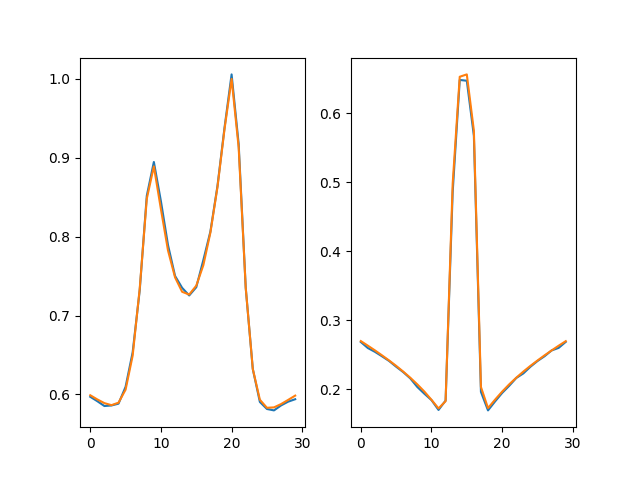

In [159]:
model.eval()
with torch.no_grad():
    x, y = next(iter(data.testLoader))
#     xPad = torch.cat((x, torch.zeros(trainer.miniBatchSize, model.totChannels - model.numXChannels, model.channelSize + model.zeroPadding)), dim=1)
#     xPadShape = xPad.shape
#     xPad = torch.reshape(xPad, (trainer.miniBatchSize, -1))
    x = x.to(dev)
    pad_fn = lambda *x: torch.zeros(*x, device=dev)
    inp = model.inSchema.fill({'ne': x[:, 0],
                                'temperature': x[:, 1],
                                'vel': x[:, 2]},
                               zero_pad_fn=pad_fn)
    yz = model(inp.to(dev))
    fig, ax = plt.subplots(1,2)
    ax[0].plot(yz[0, model.outSchema.Halpha].cpu().numpy())
    ax[0].plot(y[0, 0].numpy())
    ax[1].plot(yz[0, model.outSchema.Ca8542].cpu().numpy())
    ax[1].plot(y[0, 1].numpy()); fig.show(); fig.canvas.draw()

<IPython.core.display.Javascript object>


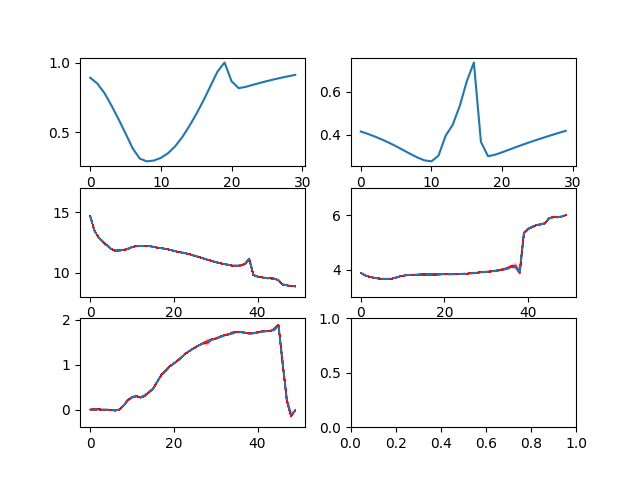

In [163]:
model.eval()
with torch.no_grad():
    x, y = next(iter(data.testLoader))
    a = max(1.0 / x.shape[0], 0.002)
    y = torch.ones_like(y) * y[0, :, :]
    yz = model.outSchema.fill({'Halpha': y[:, 0], 'Ca8542': y[:, 1], 'LatentSpace': torch.randn})
    xOut = model(yz.to(dev), rev=True)
    fig, ax = plt.subplots(3,2)
    ax[0, 0].plot(yz[0, model.outSchema.Halpha].cpu().numpy())
    ax[0, 1].plot(yz[0, model.outSchema.Ca8542].cpu().numpy())
    for i in range(x.shape[0]):
        ax[1, 0].plot(xOut[i, model.inSchema.ne].cpu().numpy(), c='r', alpha=a)
        ax[1, 1].plot(xOut[i, model.inSchema.temperature].cpu().numpy(), c='r', alpha=a)
        ax[2, 0].plot(xOut[i, model.inSchema.vel].cpu().numpy(), c='r', alpha=a)
    ax[1, 0].plot(x[0, 0].cpu().numpy(), '--')
    ax[1, 1].plot(x[0, 1].cpu().numpy(), '--')
    ax[2, 0].plot(x[0, 2].cpu().numpy(), '--')
    ax[1, 0].set_ylim(8, 17)
    ax[1, 1].set_ylim(3, 7)
    fig.canvas.draw()


In [ ]:
dev

In [ ]:
## Investigate retain_graph!!!

In [ ]:
x, y = next(iter(data.testLoader))
torch.isnan(x[:, 2]).sum()

In [ ]:
a = range(10)

In [ ]:
print(a[-1])
print(a)

In [ ]:
# mmd = Loss.mmd_multiscale_on('cpu')
def mmd_multiscale_on(dev):
    def mmd_multiscale(x, y):
        xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

        rx = (xx.diag().unsqueeze(0).expand_as(xx))
        ry = (yy.diag().unsqueeze(0).expand_as(yy))

        dxx = rx.t() + rx - 2.*xx
        dyy = ry.t() + ry - 2.*yy
        dxy = rx.t() + ry - 2.*zz

        XX, YY, XY = (torch.zeros(xx.shape).to(dev),

                      torch.zeros(xx.shape).to(dev),
                      torch.zeros(xx.shape).to(dev))

        for a in [0.2, 0.5, 0.9, 1.3, 2.4, 5.0, 10.0, 20.0, 40.0]:
#         for a in [0.05, 0.125, 0.225, 0.325]:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

        return torch.mean(XX + YY - 2.*XY)
    return mmd_multiscale
def mmd_singlescale_on(a, dev):
    def mmd_singlescale(x, y, unbiased=False):
        xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

        rx = (xx.diag().unsqueeze(0).expand_as(xx))
        ry = (yy.diag().unsqueeze(0).expand_as(yy))

        dxx = rx.t() + rx - 2.*xx
        dyy = ry.t() + ry - 2.*yy
        dxy = rx.t() + ry - 2.*zz

        XX, YY, XY = (torch.zeros(xx.shape).to(dev),

                      torch.zeros(xx.shape).to(dev),
                      torch.zeros(xx.shape).to(dev))

#         for a in [0.2, 0.5, 0.9, 1.3, 2.4, 5.0, 10.0, 20.0, 40.0]:
#         for a in [0.05, 0.125, 0.225, 0.325]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1
        
        if unbiased:
            XXUnbias = XX[~torch.eye(XX.shape[0]).byte()].reshape((XX.shape[0], -1))
            YYUnbias = YY[~torch.eye(YY.shape[0]).byte()].reshape((YY.shape[0], -1))
            return torch.mean(XXUnbias + YYUnbias) - 2.0 * torch.mean(XY)

        return torch.mean(XX + YY - 2.*XY)
    return mmd_singlescale

mmd = mmd_singlescale_on(256, 'cpu')

In [ ]:
mmd(torch.randn(300, 256), torch.ones(300, 256))

In [ ]:
batch = 100
dim = 100
loadIter = iter(data.testLoader)
x1, y1 = next(loadIter)
x2, y2 = next(loadIter)
# mmd(torch.randn(batch, dim), torch.randn(batch, dim))
mmd(x1.reshape(x1.shape[0], -1), x2.reshape(x2.shape[0], -1))
# mmd(x1.reshape(x1.shape[0], -1), torch.ones(x1.reshape(x1.shape[0], -1).shape))

# x1 = x1[:batch]
# x2 = x2[:batch]
xp = model.inSchema.fill({'ne': x1[:, 0] + 0*torch.ones(x1[:, 0].shape), 
                               'temperature': x1[:, 1] + 0*torch.ones(x1[:, 0].shape), 
                               'vel': x1[:, 2] + 0*torch.ones(x1[:, 0].shape)},
                              zero_pad_fn=torch.zeros)
xp2 = model.inSchema.fill({'ne': x2[:, 0] + 0*torch.ones(x2[:, 0].shape) + 1e-3 * torch.randn(x2[:, 1].shape), 
                               'temperature': x2[:, 1] + 0*torch.ones(x2[:, 0].shape) + 0.0 * torch.randn(x2[:, 0].shape), 
                               'vel': x2[:, 2] + 0*torch.ones(x2[:, 0].shape) + 0.0 * torch.ones(x2[:, 0].shape)},
                              zero_pad_fn=lambda *x: 0. * torch.randn(*x))
xp2s = []
for i in range(10):
    xp2s.append(model.inSchema.fill({'ne': x2[:, 0] + 0.1 *torch.ones(x2[:, 0].shape) + 0.1 * i * torch.randn(x2[:, 1].shape), 
                               'temperature': x2[:, 1] + 0*torch.ones(x2[:, 0].shape) + 0.0 * torch.randn(x2[:, 0].shape), 
                               'vel': x2[:, 2] + 0*torch.ones(x2[:, 0].shape) + 0.0 * torch.ones(x2[:, 0].shape)},
                              zero_pad_fn=lambda *x: 0.0 * i * torch.ones(*x)))
# mmd(xp, xp2).item() * 1e8

mmdVals = []
r = np.linspace(1.0, 500, num=500)
for xp2 in xp2s:
    mmdVals.append([])
    for a in r:
        mm = mmd_singlescale_on(a, 'cpu')
        mmdVals[-1].append(mm(xp, xp2).item())

plt.figure()
for x in mmdVals:
    plt.semilogx(r, x)

# 30 for channel swapping
# 12 for channel offset
# 4-6 for 0-pad noise
# 4-5 for channel noise
# 6-10 for 0-pad dist



In [ ]:
batch = 100
dim = 100
loadIter = iter(data.testLoader)
x1, y1 = next(loadIter)
x2, y2 = next(loadIter)
# mmd(torch.randn(batch, dim), torch.randn(batch, dim))
mmd(x1.reshape(x1.shape[0], -1), x2.reshape(x2.shape[0], -1))
# mmd(x1.reshape(x1.shape[0], -1), torch.ones(x1.reshape(x1.shape[0], -1).shape))

# x1 = x1[:batch]
# x2 = x2[:batch]
yp = model.outSchema.fill({'Halpha': y1[:, 0] + 0*torch.ones(y1[:, 0].shape), 
                               'Ca8542': y1[:, 1] + 0*torch.ones(y1[:, 0].shape), 
                               'LatentSpace': torch.randn},
                              zero_pad_fn=torch.zeros)
yp2 = model.outSchema.fill({'Halpha': y2[:, 0] + 0*torch.ones(y1[:, 0].shape) + 1e-3 * torch.randn(y1[:, 1].shape), 
                               'Ca8542': y2[:, 1] + 0*torch.ones(y1[:, 0].shape) + 0.0 * torch.randn(y1[:, 0].shape), 
                               'LatentSpace': torch.randn},
                              zero_pad_fn=lambda *x: 0. * torch.randn(*x))
yp2s = []
for i in range(10):
    yp2s.append(model.outSchema.fill({'Halpha': y2[:, 0] + 0*torch.ones(y2[:, 0].shape) + 1e-1 * torch.randn(y2[:, 1].shape), 
                               'Ca8542': y2[:, 1] + 0*torch.ones(y2[:, 0].shape) + 1e-1 * torch.randn(y2[:, 0].shape), 
                               'LatentSpace': lambda *x: 0.95 * torch.randn(*x) + 0.0 * torch.ones(*x)},
                              zero_pad_fn=lambda *x: 0.1 * i * torch.randn(*x)))
# mmd(xp, xp2).item() * 1e8

mmdVals = []
r = np.linspace(1.0, 500, num=500)
for yp2 in yp2s:
    mmdVals.append([])
    for a in r:
        mm = mmd_singlescale_on(a, 'cpu')
        mmdVals[-1].append(mm(yp, yp2).item())

plt.figure()
for x in mmdVals:
    plt.semilogx(r, x)

# 8-9.5-12 for channel swapping
# 12-18 for channel offset
# 4-7 for latent space dist
# 14 for latent space offset

In [ ]:
from tqdm import tqdm

In [ ]:
confidence = 0.001
bins = 20
with torch.no_grad():
    mmds = []
    mmdsEq = []
    tps = []
    r = np.logspace(-1, np.log10(20.0), num=50)
    for i in tqdm(range(1000)):
        loadIter = iter(data.testLoader)
        x1, y1 = next(loadIter)
        xp = model.inSchema.fill({'ne': x1[:, 0],
                                       'temperature': x1[:, 1],
                                       'vel': x1[:, 2]},
                                      zero_pad_fn=torch.zeros).to(dev)
        yp = model.outSchema.fill({'Halpha': y1[:, 0], 
                                       'Ca8542': y1[:, 1], 
                                       'LatentSpace': torch.randn},
                                      zero_pad_fn=torch.zeros).to(dev)
        yFor = model(xp.to(dev))
        mse = Loss.mse(yp, yFor)
        yForNp = torch.cat((yFor[:, model.outSchema.Halpha], yFor[:, model.outSchema.Ca8542], yFor[:, model.outSchema.LatentSpace]), dim=1).to(dev)
        ynp = torch.cat((yp[:, model.outSchema.Halpha], yp[:, model.outSchema.Ca8542], yp[:, model.outSchema.LatentSpace]), dim=1).to(dev)
#         yForNp = torch.cat((yFor[:, model.outSchema.Halpha], yFor[:, model.outSchema.Ca8542]), dim=1).to(dev)
#         ynp = torch.cat((yp[:, model.outSchema.Halpha], yp[:, model.outSchema.Ca8542]), dim=1).to(dev)
#         yForNp = yFor[:, model.outSchema.LatentSpace].to(dev)
#         ynp = yForNp.clone()
#         ynp = yp[:, model.outSchema.LatentSpace].to(dev)
        
        yForNpEq = torch.zeros_like(yForNp)
        yForNpEq[::2] = yForNp[::2]
        yForNpEq[1::2] = ynp[1::2]
        yNpEq = torch.zeros_like(ynp)
        yNpEq[::2] = ynp[::2]
        yNpEq[1::2] = yForNp[1::2]


        mmdVals = []
        mmdEqVals = []
        for a in r:
            mm = mmd_singlescale_on(float(a), dev)
            mmdVals.append(mm(yForNp, ynp, unbiased=True).item())
            mmdEqVals.append(mm(yForNpEq, yNpEq, unbiased=True).item())

        mmdVals = np.array(mmdVals)
        mmdEqVals = np.array(mmdEqVals)
        def find_turning_rev(a):
            aRev = a[::-1]
            for i, v in enumerate(a[-2::-1]):
                if v < aRev[i]:
                    return len(a)-i


#         tp = find_turning_rev(mmdVals)
        tp = find_turning_rev(np.abs(mmdEqVals))
        tp = np.searchsorted(r, 2.0) if tp is None or tp == len(r) else tp
        mmds.append(yNpEq.shape[0] * mmdVals)
        mmdsEq.append(yNpEq.shape[0] * mmdEqVals)
        tps.append(tp)
        
    mmds = np.array(mmds)
    mmdsEq = np.array(mmdsEq)
    tps = np.array(tps)
#     histAlphas = sorted([0.1, 1.0, 10.0, 100.0, 300.0, np.mean(r[tps])])
    histAlphas = sorted([np.mean(r[tps])])
    histIdxs = [np.searchsorted(r, a) for a in histAlphas]
        
    fig, ax = plt.subplots(1, 2)
    
    weights = np.ones_like(mmdsEq[:,0])
    weights /= len(weights)
    for i, idx in enumerate(histIdxs):
        
        hist = ax[1].hist(mmdsEq[:, idx], label=r'P=Q, $\alpha$=%.1f' % histAlphas[i], alpha=0.6, bins=bins, weights=weights)
        cumSum = np.cumsum(hist[0])
        confIdx = np.searchsorted(cumSum, 1.0 - confidence)
        confVal = 0.5*(hist[1][confIdx] + hist[1][confIdx+1])
        ax[1].axvline(confVal, linestyle='-.', color=hist[2][0].get_facecolor(), alpha=1)
        
        hist = ax[0].hist(mmds[:, idx], label=r'$\alpha$=%.1f' % histAlphas[i], alpha=0.6, bins=bins, weights=weights)
        ax[0].axvline(confVal, linestyle='-.', color=hist[2][0].get_facecolor(), alpha=1)
        
    ax[0].legend()
    ax[1].legend()
#     plt.semilogx(r[tp], mmdVals[tp], 'go')

In [ ]:
plt.figure()
plt.semilogx(r, mmds[5])
plt.semilogx(r, mmdsEq[5])

In [ ]:
tps

In [ ]:


c = np.cumsum(hist[0])
confIdx = np.searchsorted(c, 0.5)
0.5*(hist[1][confIdx] + hist[1][confIdx+1])

In [ ]:
def find_turning_rev(a):
    aRev = a[::-1]
    for i, v in enumerate(a[-2::-1]):
        if v < aRev[i]:
            return min(len(a)-i, len(a)-1)

In [ ]:
with torch.no_grad():
    loadIter = iter(data.testLoader)
    x1, y1 = next(loadIter)
    xp = model.inSchema.fill({'ne': x1[:, 0],
                                   'temperature': x1[:, 1],
                                   'vel': x1[:, 2]},
                                  zero_pad_fn=torch.zeros).to(dev)
    yp = model.outSchema.fill({'Halpha': y1[:, 0], 
                                   'Ca8542': y1[:, 1], 
                                   'LatentSpace': torch.randn},
                                  zero_pad_fn=torch.zeros).to(dev)
    xBack = model(yp, rev=True)
    mse = Loss.mse(xp, xBack)
#     xBackNp = torch.cat((xBack[:, model.inSchema.ne], xBack[:, model.outSchema.temperature], xBack[:, model.outSchema.vel], yFor[:, model.outSchema.LatentSpace]), dim=1).to(dev)
#     ynp = torch.cat((yp[:, model.outSchema.Halpha], yp[:, model.outSchema.Ca8542], yp[:, model.outSchema.LatentSpace]), dim=1).to(dev)


    r = np.logspace(-3, np.log10(500), num=1000)
    mmdVals = []
    for a in r:
        mm = mmd_singlescale_on(float(a), dev)
        mmdVals.append(mm(xp[:, model.inSchema.ne[0]:model.inSchema.vel[-1]+1], xBack[:, model.inSchema.ne[0]:model.inSchema.vel[-1]+1]).item())
        
    mmdVals = np.array(mmdVals)
    tp = find_turning_rev(mmdVals)
    
        
    plt.figure()
    plt.semilogx(r, mmdVals)
    plt.semilogx(r[tp], mmdVals[tp], 'go')

In [ ]:
trainer.loss_latent(yForNp, ynp)

In [ ]:
dev

In [ ]:
mse

In [ ]:
plt.figure()
plt.plot(yFor[20, model.outSchema.LatentSpace].cpu().numpy())